#Advanced Data Analysis Project
##Elon musk quotes and Tesla stock price 



In [ ]:
import json 
import bz2
import csv 
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt
import pandas_datareader as web 
import re, string
import nltk 
from nltk.corpus import wordnet 
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer 
from textblob import TextBlob
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


True

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!pip install --upgrade pandas
!pip install --upgrade pandas-datareader

***Crate two lists with the paths containing the files to read and where to write the new filtered ones***

In [ ]:
path_to_file = [ '/content/drive/MyDrive/Quotebank/quotes-2020.json.bz2', 
                 '/content/drive/MyDrive/Quotebank/quotes-2019.json.bz2',
                 '/content/drive/MyDrive/Quotebank/quotes-2018.json.bz2',
                 '/content/drive/MyDrive/Quotebank/quotes-2017.json.bz2',
                 '/content/drive/MyDrive/Quotebank/quotes-2016.json.bz2',
                 '/content/drive/MyDrive/Quotebank/quotes-2015.json.bz2',
]
path_to_out = ['/content/drive/MyDrive/2020-ElonMusk.json.bz2',
               '/content/drive/MyDrive/2019-ElonMusk.json.bz2',
               '/content/drive/MyDrive/2018-ElonMusk.json.bz2',
               '/content/drive/MyDrive/2017-ElonMusk.json.bz2',
               '/content/drive/MyDrive/2016-ElonMusk.json.bz2',
               '/content/drive/MyDrive/2015-ElonMusk.json.bz2']


***We first load all the QuoteBank data but only write on new files quotes that have Elon Musk as a speaker from 2015 to 2020***

In [ ]:
for path_to, path_out in zip(path_to_file,path_to_out):
  with bz2.open(path_to, 'rb') as s_file:
    with bz2.open(path_out, 'wb') as d_file:
        for instance in s_file:
            instance = json.loads(instance) # loading a sample
            if instance['speaker'] == 'Elon Musk':
               d_file.write((json.dumps(instance)+'\n').encode('utf-8')) # writing in the new file

***The json file obtained for each year are loaded into a single dataframe***

In [ ]:
df_musk = pd.DataFrame()
for path in path_to_out:
  df = pd.read_json(path, lines=True)
  df_musk = pd.concat([df,df_musk],ignore_index=True)
df_musk

,quoteID,quotation,speaker,qids,date,numOccurrences,probas,urls,phase
0,2015-08-07-046061,If I had to guess at what our biggest existent...,Elon Musk,[Q317521],2015-08-07 21:25:54,1,"[[Elon Musk, 0.7445], [None, 0.2555]]",[http://techcrunch.com/2015/08/07/how-consumer...,E
1,2015-03-17-093153,"We can make car steer itself on freeway, do la...",Elon Musk,[Q317521],2015-03-17 19:25:00,2,"[[Elon Musk, 0.8777], [None, 0.1223]]",[http://businessinsider.com/tesla-ceo-elon-mus...,E
2,2015-12-15-017500,digital intelligence in the way that is most l...,Elon Musk,[Q317521],2015-12-15 00:00:00,54,"[[Elon Musk, 0.5269], [None, 0.3189], [Sam Alt...",[http://abcnews.go.com/Technology/wireStory/te...,E
3,2015-03-19-110498,where if you take your hand off the wheel the ...,Elon Musk,[Q317521],2015-03-19 19:27:17,2,"[[Elon Musk, 0.9395], [None, 0.0605]]",[http://blog.caranddriver.com/tesla-software-u...,E
4,2015-12-19-003843,Artificial intelligence has always been a surp...,Elon Musk,[Q317521],2015-12-19 18:36:09,1,"[[Elon Musk, 0.7974], [None, 0.1826], [Peter T...",[http://feeds.inquisitr.com/~r/google/yDYq/~3/...,E
...,...,...,...,...,...,...,...,...,...
43596,2020-01-22-073958,Since the spacecraft has an extremely effectiv...,Elon Musk,[Q317521],2020-01-22 12:14:35,1,"[[Elon Musk, 0.7524], [None, 0.1991], [Loren G...",[https://tecake.in/can-apple-live-up-to-apples...,E
43597,2020-03-21-026450,"probably won't be needed,",Elon Musk,[Q317521],2020-03-21 00:00:00,3,"[[Elon Musk, 0.8889], [None, 0.1087], [Warren ...",[https://www.forbes.com/sites/hayleycuccinello...,E
43598,2020-03-30-026197,in the not-bankrupt category.,Elon Musk,[Q317521],2020-03-30 16:32:02,1,"[[Elon Musk, 0.8683], [None, 0.1317]]",[https://arstechnica.com/information-technolog...,E
43599,2020-03-12-066727,the stock market was too high and was due a co...,Elon Musk,[Q317521],2020-03-12 06:30:20,1,"[[Elon Musk, 0.542], [None, 0.4297], [Amancio ...",[http://www.albawaba.com/business/these-6-bill...,E


***We select from our dataframe all the quotes that contains the key world tesla and others in order to create a new data frame with these quotes***

In [ ]:
filtered_indexes = []
key_word = ['tesla','bitcoin','spacex']
length = len(df_musk.quotation)
for k in range(len(key_word)):
  for i in range (length):
    quote = df_musk.iloc[i]['quotation']
    if key_word[k] in quote.lower():
        filtered_indexes.append(i)

print(len(tesla_indexes))
filtered_df = df_musk.iloc[filtered_indexes] #creates a dataframe with all the quotes containing our keywords

4693


***1. Importing tesla stock price from Yahoo Finance***

In [ ]:
tesla = web.get_data_yahoo("TSLA",
                            start = "2015-01-02",
                            end = "2020-12-30")
tesla.head()

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2015-01-02,44.650002,42.652000,44.574001,43.862000,23822000.0,43.862000
2015-01-05,43.299999,41.431999,42.910000,42.018002,26842500.0,42.018002
2015-01-06,42.840000,40.841999,42.012001,42.256001,31309500.0,42.256001
2015-01-07,42.956001,41.956001,42.669998,42.189999,14842000.0,42.189999
2015-01-08,42.759998,42.001999,42.562000,42.124001,17212500.0,42.124001


***Plot the evolution of Tesla stock price over time***


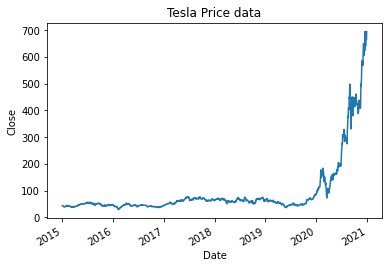

In [ ]:
tesla['Close'].plot()
plt.xlabel("Date")
plt.ylabel("Close")
plt.title("Tesla Price data")
plt.show()

***Calculating and plotting the daily returns of Tesla stock***

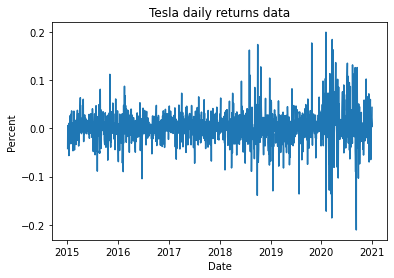

In [ ]:
tesla['returns'] = tesla['Close'].pct_change()
tesla.head()
plt.plot(tesla.returns)
plt.xlabel("Date")
plt.ylabel("Percent")
plt.title("Tesla daily returns data")
plt.show()

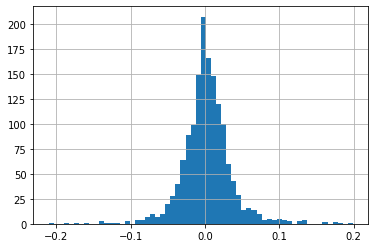

In [ ]:
#to get a sense of how extreme the returns can be we can plot a histogram.
tesla.returns.hist(bins=60)

**Cleaning the quotations**
 
This function will prepare the quotations so that we can use them afterwards to perform analysis, basically it will do the following: 


*   Transform to lower case, remove all that is not words or numbers.  
*   Tokenization meaning breaking up every quotation into a group of indivudual words.
*   Remove stopwords which does not add much information to the quotations. 



In [ ]:
#nltk.download('stopwords')
sw = stopwords.words('english')
def clean_quotation(quotation):
  quotation = quotation.lower()
  quotation = re.sub('@', '', quotation)
  quotation = re.sub('\n', '', quotation)
  quotation = re.sub('[%s]' % re.escape(string.punctuation), '', quotation)
  #Tokenization 
  quotation = nltk.word_tokenize(quotation)

  #Removing stopwords
  quotation_without_sw = [word for word in quotation if not word in sw]

  return quotation_without_sw


In [ ]:
filtered_df['prepQuot'] = filtered_df['quotation'].apply(lambda x: clean_quotation(x))


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [ ]:
filtered_df.head

<bound method NDFrame.head of                  quoteID  ...                                           prepQuot
9      2015-10-14-022047  ...  [elon, musk, apple, hired, tesla, engineers, w...
52     2015-10-09-112605  ...  [hired, people, weve, fired, always, jokingly,...
69     2015-04-01-106327  ...  [going, unveil, tesla, home, battery, sort, co...
142    2015-08-20-128647  ...  [believe, applying, opensource, philosophy, pa...
157    2015-10-23-088862  ...  [tesla, gets, top, rating, company, service, i...
...                  ...  ...                                                ...
43439  2020-01-14-061750  ...  [prior, launch, spacex, nasa, teams, practice,...
43453  2020-02-07-076183  ...  [spacex, public, company, experience, may, thi...
43459  2020-03-20-057283  ...  [tesla, makes, cars, sophisticated, hvac, heat...
43468  2020-01-28-014771  ...  [critically, tank, reached, maximum, sustained...
43594  2020-03-19-059397  ...  [tesla, makes, cars, sophisticated, hvac, syst..

**Lemmatization**

Here we are grouping the inflected forms of a word so we can analyze them as a single item. 


In [ ]:
#identifies the role of the word in the sentence 
def get_wordnet_pos(word):
    tag = nltk.pos_tag([word])[0][1][0].upper()
    tag_dict = {"J": wordnet.ADJ,
                "N": wordnet.NOUN,
                "V": wordnet.VERB,
                "R": wordnet.ADV}

    return tag_dict.get(tag, wordnet.NOUN)

In [ ]:
# Initialize Lemmatizer
lemmatizer = WordNetLemmatizer()

def lematization(wordsInQuotation):
  lem_words = []
  for i in range(len(wordsInQuotation)):
    lem_words.append(lemmatizer.lemmatize(wordsInQuotation[i], get_wordnet_pos(wordsInQuotation[i])))
    
  lem_quotation =  ' '.join(lem_words)
  return lem_quotation



In [ ]:
filtered_df['prepQuot'] = filtered_df['prepQuot'].apply(lambda x: lematization(x))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [ ]:
filtered_df['prepQuot']

9            elon musk apple hire tesla engineer weve fire
52       hire people weve fire always jokingly call app...
69       go unveil tesla home battery sort consumer bat...
142      believe apply opensource philosophy patent str...
157      tesla get top rating company service important...
                               ...                        
43439    prior launch spacex nasa team practice launch ...
43453    spacex public company experience may think pub...
43459    tesla make car sophisticated hvac heating vent...
43468    critically tank reach maximum sustain pressure...
43594    tesla make car sophisticated hvac system space...
Name: prepQuot, Length: 4693, dtype: object